In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'goog' # ticker symbol
model_name = 'Random Forest Classifier' # for display later
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds

In [3]:
# Extract, Transform, Load, and Train Test Split
# aapl start date: 12/12/1980, trained 12/23/20
# tsla start date: 06/29/2010, trained 12/23/20
# vbiv start date: 09/04/2002, trained 12/23/20
# vgt start date: 01/26/2004, trained 12/23/20
# idex start date: 05/23/2007, trained 12/23/20
# iyw start date: 05/15/2000, trained 12/23/20
# 
start_dates = {'aapl':'12/12/1980'
               , 'baba': '09/15/2014'
               , 'crm': '06/23/2004'
               , 'goog': '08/16/2004'
               , 'idex': '05/23/2007'
               , 'iyw': '05/15/2000'
               , 'nvda': '01/22/1999'
               , 'pypl': '07/05/2015'
               , 'tsla': '06/29/2010'
               , 'vbiv': '09/04/2002'
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-11,215.000000,210.419998,213.389999,214.059998,4283400,214.059998,-0.003140,0.021766,-0.005944,0.017796,-0.003304,1
2020-12-14,223.160004,215.000000,215.949997,220.789993,9759400,220.789993,-0.022413,0.037954,0.031440,0.023817,0.002837,-1
2020-12-15,222.309998,217.119995,221.929993,221.600006,6508100,221.600006,0.001487,0.023904,0.003669,0.023462,0.004480,1
2020-12-16,231.149994,224.610001,224.800003,230.199997,10110000,230.199997,-0.024021,0.029117,0.038809,0.018740,0.017902,-1
2020-12-17,238.100006,232.399994,234.509995,235.509995,8914100,235.509995,-0.004264,0.024527,0.023067,0.018827,0.018208,-1
2020-12-18,237.169998,232.279999,236.660004,236.449997,11534700,236.449997,0.000887,0.021052,0.003991,0.015944,0.020195,1
2020-12-21,239.751007,232.201004,232.619995,237.720001,8156000,237.720001,-0.021924,0.032515,0.005371,0.015606,0.014981,1
2020-12-22,243.679993,238.089996,240.164993,243.490005,6331700,243.490005,-0.013845,0.023479,0.024272,0.014557,0.019102,-1
2020-12-23,244.250000,238.330002,243.600006,239.440002,6421300,239.440002,0.017077,0.024840,-0.016633,0.016745,0.008014,1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)

/home/david/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.67121951 0.67121951 0.67121951]
  warnings.warn(


In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

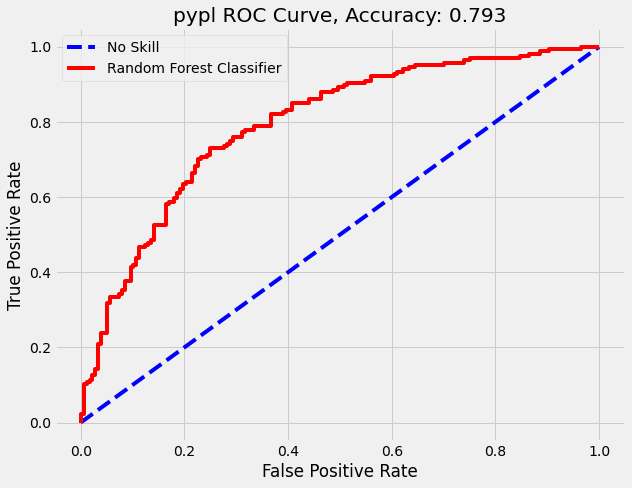

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

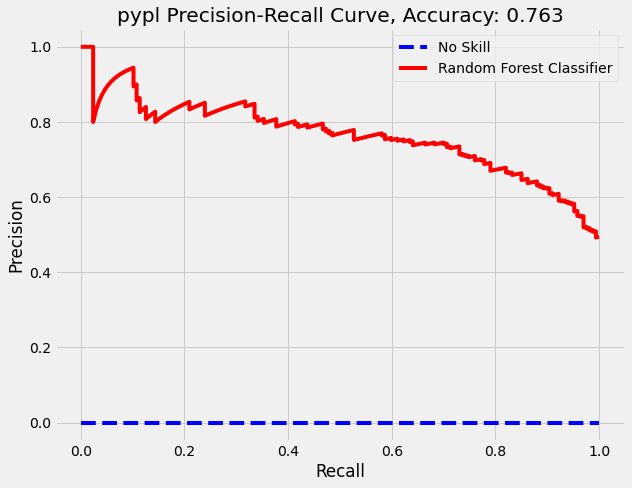

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

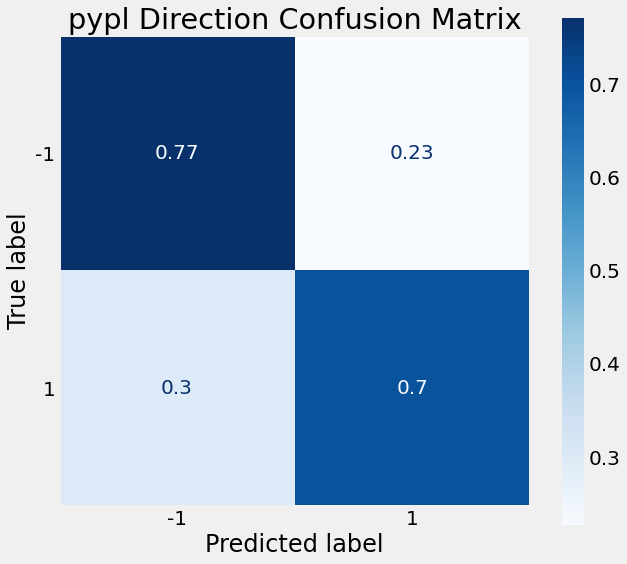

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.6976864295125165'

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          2.421200e+02
Low           2.380900e+02
Open          2.403600e+02
Close         2.386400e+02
Volume        3.053800e+06
Adj Close     2.386400e+02
oc            7.155938e-03
hl            1.692637e-02
adj          -3.341142e-03
5stdev_adj    1.486965e-02
5sma_adj      2.732094e-03
direction    -1.000000e+00
Name: 2020-12-24 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc            0.007156
hl            0.016926
5stdev_adj    0.014870
5sma_adj      0.002732
Name: 2020-12-24 00:00:00, dtype: float64

### Prediction...

In [13]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Buy pypl


In [14]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [15]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-18,237.169998,232.279999,236.660004,236.449997,11534700,236.449997,0.000887,0.021052,0.003991,0.015944,0.020195,1,-1,-0.005371
2020-12-21,239.751007,232.201004,232.619995,237.720001,8156000,237.720001,-0.021924,0.032515,0.005371,0.015606,0.014981,1,-1,-0.024272
2020-12-22,243.679993,238.089996,240.164993,243.490005,6331700,243.490005,-0.013845,0.023479,0.024272,0.014557,0.019102,-1,-1,0.016633
2020-12-23,244.250000,238.330002,243.600006,239.440002,6421300,239.440002,0.017077,0.024840,-0.016633,0.016745,0.008014,1,1,-0.003341
2020-12-24,242.119995,238.089996,240.360001,238.639999,3053800,238.639999,0.007156,0.016926,-0.003341,0.014870,0.002732,-1,1,0.001416


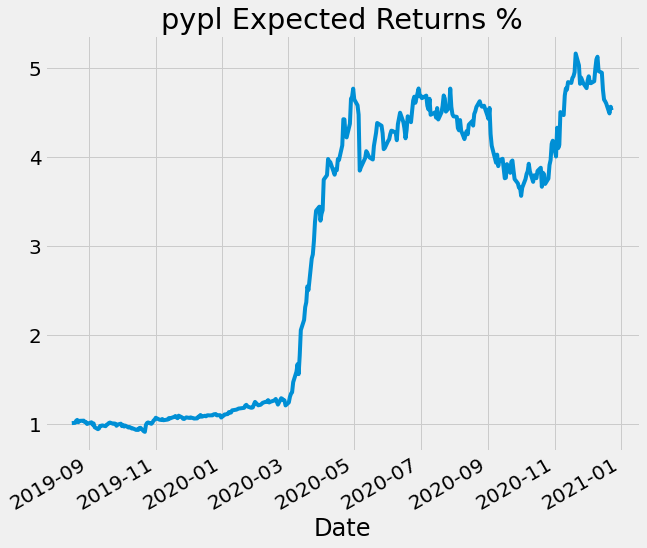

In [16]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [17]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

3.4548534230651238

In [18]:
# multiple times original investment, not bad but...

In [19]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) /stock_df['Close'][-test_idx]

4.954091529126278

In [20]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/